# 05a Cell search for GI outcome



### Contents:
1. Set up and preparation for cell search  
1.1. Fit the top ensemble  
1.2. Find important features  
1.3. Determine most significant q values
2. Cell search  
3. Examining cell search results  
3.1. Coverage of quantile-based top subgroups by cell union  
3.2. Significance of selected cells  
3.3. Significance of selected cells w.r.t. TC outcome  
3.4. Similarity of selected cells
4. Results on test set  
4.1. Significance of selected cells  
4.2. Significance of selected cells w.r.t. TC outcome  
4.3. Significance of selected cells w.r.t. TC outcome, on TC-based split  
4.4. Significance of selected cells w.r.t. TC outcome, on all data

## 1. Set up and preparation for cell search

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import sys
import copy
import random
import joblib

# Plotting libraries
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib as mpl
import pylab

# Import own methods
from methods.data_processing import prepare_df, separate_vars
from methods.causal_functions import get_Neyman_ATE, get_Neyman_var
from methods.cate_estimator_wrappers import combine_estimator_versions
from methods.cate_estimator_validation import make_top_ensemble, get_top_subgroup_stability
from methods.cell_search import (get_feature_importance_scores, compare_q_values,
                                 CellSearch, get_cell_search_results,
                                 aggregate_cell_search_results, 
                                 get_coverage_results, get_cell_overlap_results, 
                                 get_cell_significance_results, get_RR_results)

Failed to import duecredit due to No module named 'duecredit'


In [6]:
# Load dataset configuration from 02 (features, treatment, outcomes)
from pathlib import Path
import pickle

outcome = "fausebal"
IMPUTATION_META = Path(f"output/params/{outcome}/analysis_imputation_meta.pkl")
if not IMPUTATION_META.exists():
    raise FileNotFoundError("Missing imputation metadata from 02. Run 02_tune_CATE_estimators.ipynb first.")
with open(IMPUTATION_META, 'rb') as f:
    _meta = pickle.load(f)

features = _meta["features"]
# Direction: infer from ATE on imputed dataset if needed later
n_splits = 4
q_values = np.array([0.1, 0.2, 0.3, 0.4, 0.5])
dir_neg = False

# Paths for cached results
FILE_PATH = f"output/analysis/{outcome}/"
Path(FILE_PATH).mkdir(parents=True, exist_ok=True)

If notebook has already been run before, load cache of intermediate results using this cell.

In [7]:
# Load or build intermediate results aligned with current dataset
import os
from pathlib import Path

# Try to load fitted libraries from 03a/03b style cache
FITTED_LIBS_PATH = Path(FILE_PATH) / f"{outcome}_fitted_libraries.pkl"
TOP_NAMES_PATH = Path(FILE_PATH) / f"{outcome}_top_estimator_names.pkl"
TOP_ENSEMBLE_PATH = Path(FILE_PATH) / f"{outcome}_top_ensemble.pkl"
TOP_FEATURES_PATH = Path(FILE_PATH) / f"{outcome}_top_features.pkl"
CELL_SEARCH_PATH = Path(FILE_PATH) / f"{outcome}_cell_search_results.pkl"
PARAMS_PATH = Path(f'output/params/{outcome}') / f'{outcome}_tuned_params.pkl'

tuned_params = joblib.load(PARAMS_PATH)
fitted_libraries = joblib.load(FITTED_LIBS_PATH)
top_estimator_names = joblib.load(TOP_NAMES_PATH)

### 1.1. Fit the top ensemble

In [8]:
# Fit/load the top ensemble using current cache
# Fit the top ensemble
top_ensemble = make_top_ensemble(fitted_libraries, top_estimator_names)

In [9]:
print("Top ensemble estimators are:")
for idx, estimator_name in enumerate(top_estimator_names):
    print(idx + 1, estimator_name)

Top ensemble estimators are:
1 s_xgb
2 t_rf
3 causal_tree_2
4 t_xgb
5 r_rflasso
6 r_xgblasso
7 r_lassolasso


### 1.2. Find significant quantile

In [10]:
compare_q_values(top_ensemble, q_values, dir_neg=dir_neg).round(2)

t-stat mean  t-stat std  overlap mean
0.1         0.24        0.35          0.40
0.2         0.09        0.21          0.48
0.3         0.09        0.23          0.56
0.4         0.08        0.18          0.64
0.5        -0.10        0.16          0.71

In [11]:
q0 = 0.1
get_top_subgroup_stability(top_ensemble, q0, q_values, dir_neg=dir_neg).round(2)

mean coverage  coverage std
0.1           0.41          0.04
0.2           0.58          0.05
0.3           0.71          0.05
0.4           0.80          0.05
0.5           0.87          0.04

### 1.3. Find important features

In [12]:
# Load or compute cached feature importance DataFrames
MEAN_DIFF_PATH = Path(FILE_PATH) / f"{outcome}_mean_difference_df.pkl"
LOG_COEF_PATH = Path(FILE_PATH) / f"{outcome}_log_coef_df.pkl"


def _cache_valid(df):
    try:
        return set(q_values).issubset(set(df.columns))
    except Exception:
        return False

mean_difference_df = None
log_coef_df = None

if MEAN_DIFF_PATH.exists() and LOG_COEF_PATH.exists():
    try:
        mean_difference_df = joblib.load(MEAN_DIFF_PATH)
        log_coef_df = joblib.load(LOG_COEF_PATH)
        if not (_cache_valid(mean_difference_df) and _cache_valid(log_coef_df)):
            raise ValueError("Cached importance frames incompatible with current q_values.")
        print("Loaded cached feature importance frames.")
    except Exception:
        mean_difference_df = None
        log_coef_df = None

if mean_difference_df is None or log_coef_df is None:
    mean_difference_df = get_feature_importance_scores(top_ensemble, "mean_difference", q_values, features, dir_neg)
    log_coef_df = get_feature_importance_scores(top_ensemble, "log_coef", q_values, features, dir_neg)
    joblib.dump(mean_difference_df, MEAN_DIFF_PATH)
    joblib.dump(log_coef_df, LOG_COEF_PATH)
    print(f"Computed and cached feature importance at {MEAN_DIFF_PATH.name} and {LOG_COEF_PATH.name}")

d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable

Computed and cached feature importance at fausebal_mean_difference_df.pkl and fausebal_log_coef_df.pkl


d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 300 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=300).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


We rank the features by taking the mean over the scores for q=0.05.

In [13]:
qs = [0.1]
df2 = pd.DataFrame(log_coef_df[qs].mean(1), columns=["mean"])
df1 = pd.DataFrame(mean_difference_df[qs].mean(1), columns=["mean"])

q_pick = "mean"

df2[q_pick] = np.abs(df2[q_pick])
df2 = df2.sort_values(q_pick, ascending=False)

df1[q_pick] = np.abs(df1[q_pick])
df1 = df1.reindex(df2.index)

In [19]:
mean_difference_top = df1.sort_values(q_pick, ascending = False)[:6]
log_coef_top = df2.sort_values(q_pick, ascending = False)[:6]

top_features = np.unique(np.hstack((mean_difference_top.index, log_coef_top.index)))
print("Top features are:", top_features)
print("Num top features:", len(top_features))

Top features are: ['assets' 'debt' 'deposits' 'htefa' 'minbal' 'paymentmean' 'strat_23'
 'strat_4' 'strat_63' 'strat_67' 'strat_82']
Num top features: 11


Let's now plot the scores.

In [20]:
# Plot style settings
plt.style.use("fivethirtyeight")
label_size = 22
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
mpl.rcParams['axes.labelsize'] = label_size
mpl.rcParams['axes.titlesize'] = label_size
mpl.rcParams['figure.titlesize'] = label_size
mpl.rcParams['lines.markersize'] = 10
mpl.rcParams['grid.linewidth'] = 2.5
mpl.rcParams['legend.fontsize'] = 20
pylab.rcParams['xtick.major.pad'] = 5
pylab.rcParams['ytick.major.pad'] = 5
mpl.rcParams["figure.figsize"] = [8, 6]
mpl.rcParams['savefig.transparent'] = True


plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['figure.edgecolor'] = 'black'
# plt.rcParams['patch.edgecolor'] = 'white'
plt.rcParams['axes.facecolor'] = 'white'
# plt.rcParams['grid.color'] = 'black'

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

SAVE_PATH  = f"output/figures/{outcome}/"

In [24]:
imp_type =  ["Logistic"]*6
imp_type += ["Difference"]*6

In [25]:
d = {'values': np.hstack((mean_difference_top.values.T[0]/sum(mean_difference_top.values), 
                          log_coef_top.values.T[0]/sum(log_coef_top.values))),
     "feature" : np.hstack((mean_difference_top.index, log_coef_top.index)),
     'type': imp_type}
#joblib.dump(d, "data_files/GI/GI_feat_imp")

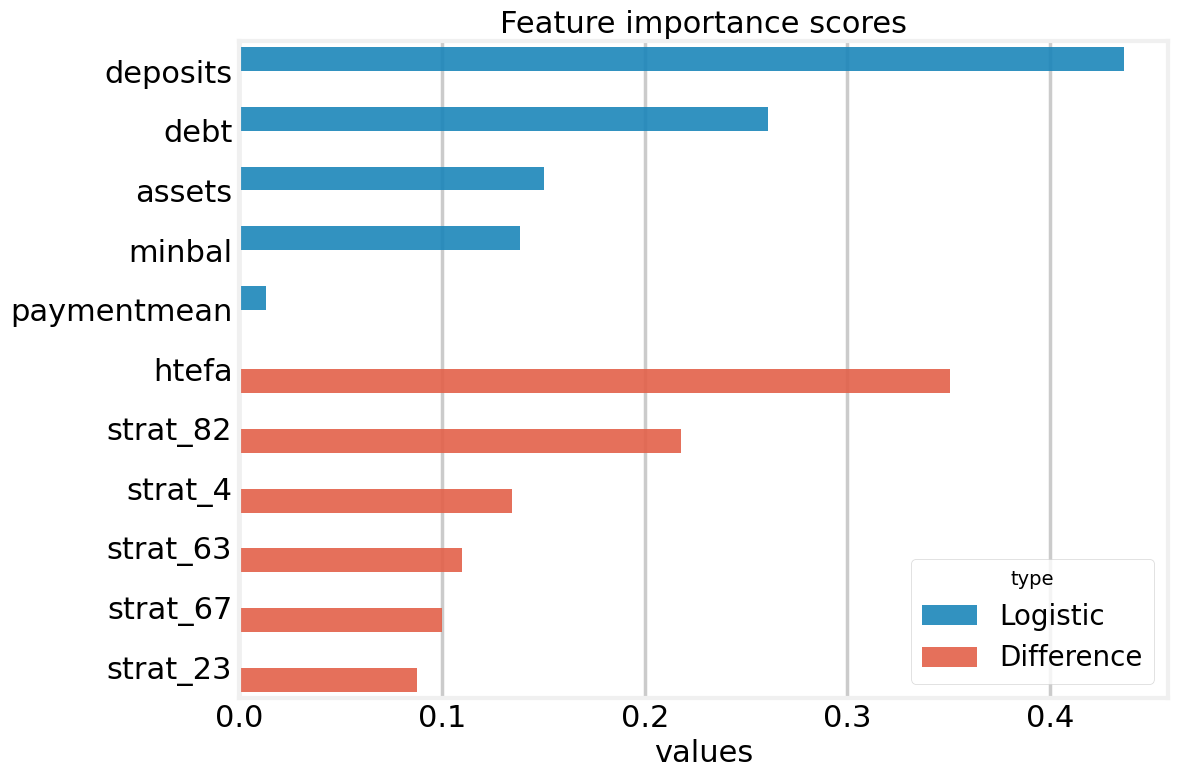

In [26]:
savfig = False
temp_df = pd.DataFrame(d)
fig, ax = plt.subplots(figsize=[12, 8])
sns.barplot(y='feature', x='values', hue='type', data=temp_df,  orient='h', ax=ax, alpha=0.9)
ax.set_ylabel('')
plt.title("Feature importance scores")
plt.tight_layout()
if savfig:
    plt.savefig(SAVE_PATH + f"{outcome}_feat_imp.pdf")
plt.show()

## 2. Cell search

A new cell search algorithm is implemented. Instead of searching all feature combinations, we simply
walk through all sets of units defined by unique feature combinations. For each set, we calculate TP
as the frequency of units lying in the target set, and FP as that outside the target set. We then rank
TP-FP scores in order to find a cover of target set using the greedy search algorithm.

We perform multiple runs of cell search, by varying the training fold used to train  
the estimator.

In [50]:
# Options for cell search
outcome = "fausebal"
# dir_neg already set from setup
trainval_df = pd.read_csv(f"output/analysis/{outcome}/trainval_data.csv")

In [51]:
try:
    search_results_df = joblib.load(Path(FILE_PATH) / f"{outcome}_cell_search_results.pkl")
except:
    from methods.greedy_cell_search import greedy_get_cell_search_results
    search_results_df = greedy_get_cell_search_results(
        top_ensemble,
        all_features=features,
        top_features=top_features,
        q_values=[0.1],      # adjust as needed
        dir_neg=dir_neg,
        n_reps=1,
        verbose=False
    )
    joblib.dump(search_results_df, Path(FILE_PATH) / f"{outcome}_cell_search_results.pkl")

In [52]:
aggregated_results_df = aggregate_cell_search_results(search_results_df, trainval_df[features], 
                                                      collapse_cells = True).round(2)
aggregated_results_df

q=0.05  num runs  \
cells                                                                  
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...     9.0        12   
(camp_short_1.0, creditcard_bin_2.0_False, debt...     8.0        12   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...     8.0        12   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...     7.0        12   
(camp_short_1.0, creditcard_bin_2.0_False, debt...     7.0        12   
...                                                    ...       ...   
(camp_short_1.0, creditcard_bin_2.0_False, remi...     1.0        12   
(camp_short_1.0, creditcard_bin_2.0_False, debt...     1.0        12   
(camp_short_1.0, creditcard_bin_2.0_False, debt...     1.0        12   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...     1.0        12   
(camp_short_1.0, creditcard_bin_2.0_False, debt...     1.0        12   

                                                    total frequency  \
cells                                                                 
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...             0.75   
(camp_short_1.0, creditcard_bin_2.0_False, debt...             0.67   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...             0.67   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...             0.58   
(camp_short_1.0, creditcard_bin_2.0_False, debt...             0.58   
...                                                             ...   
(camp_short_1.0, creditcard_bin_2.0_False, remi...             0.08   
(camp_short_1.0, creditcard_bin_2.0_False, debt...             0.08   
(camp_short_1.0, creditcard_bin_2.0_False, debt...             0.08   
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...             0.08   
(camp_short_1.0, creditcard_bin_2.0_False, debt...             0.08   

                                                    max frequency  
cells                                                              
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...           0.75  
(camp_short_1.0, creditcard_bin_2.0_False, debt...           0.67  
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...           0.67  
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...           0.58  
(camp_short_1.0, creditcard_bin_2.0_False, debt...           0.58  
...                                                           ...  
(camp_short_1.0, creditcard_bin_2.0_False, remi...           0.08  
(camp_short_1.0, creditcard_bin_2.0_False, debt...           0.08  
(camp_short_1.0, creditcard_bin_2.0_False, debt...           0.08  
(creditcard_bin_2.0_False, debt_bin_0.0_True, c...           0.08  
(camp_short_1.0, creditcard_bin_2.0_False, debt...           0.08  

[152 rows x 4 columns]

We now simplify this table for display in the paper. We rank the cells according to their "mean",  
i.e. the mean of the frequency with which they were selected for each q value.

In [59]:
threshold = 1/3
q_cols = [c for c in aggregated_results_df.columns if c.startswith("q=")]

mask = (aggregated_results_df[q_cols]
        .div(aggregated_results_df["num runs"], axis=0) >= threshold).all(axis=1)

selected_cells_df = aggregated_results_df[mask]
top_cells = list(selected_cells_df.index)

## 3. Examining cell search results

### 3.1. Coverage of quantile-based top subgroups by cell union

This first table shows the coverage statistics of the cells selected with respect to various q values.

In [60]:
coverage_results_df = get_coverage_results(top_cells, trainval_df, top_ensemble, 
                                           q_values, dir_neg)
coverage_results_df.round(2)

TP mean  FP mean  FN mean   TP std   FN std
0.1   6535.5  29063.5   4241.5  1664.41  1661.37

### 3.2. Significance of selected cells

The next two tables display the CATE, $t$-statistic and relative risk of the selected cells as well as their union.

In [61]:
# Use the imputed trainval_df aligned with 02
trainval_df = trainval_df.copy()

In [62]:
sig_cate = get_cell_significance_results(top_cells, trainval_df[outcome].values, 
                                         trainval_df["TREATED"].values, trainval_df[features], on_trainval=False)
sig_cate.round(3)

d:\statistics\jofe\causal-targeting-main\methods\causal_functions.py:21: RuntimeWarning: Mean of empty slice.
  ATE_ = y1_obs.mean() - y0_obs.mean()
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:145: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\fromnumeric.py:4268: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:181: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
d:\statistics\jofe\causal-targeting-main\venv\Lib\site-packages\numpy\_core\_methods.py:215: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
d:\statistics\jofe\causal-targeting-main\methods\causal_f

size  num_evts   CATE  \
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...     69        20    NaN   
camp_short==1.0 & creditcard_bin_2.0=="False" &...     75        25    NaN   
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...    160        46 -0.107   
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...    831       493    NaN   
camp_short==1.0 & creditcard_bin_2.0=="False" &...   4293      1032    NaN   
...                                                   ...       ...    ...   
camp_short==1.0 & debt_bin_0.0=="True" & remind...     77        23    NaN   
camp_short==1.0 & reminder_infreq==0.0 & debt_b...      1         1    NaN   
creditcard_bin_2.0=="False" & camp_short==0.0 &...     96        49 -0.015   
creditcard_bin_2.0=="False" & camp_short==0.0 &...    108        60    NaN   
union                                               35599     11913  0.031   

                                                    CATE_std  t-stat (overall)  
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...       NaN               NaN  
camp_short==1.0 & creditcard_bin_2.0=="False" &...       NaN               NaN  
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...     0.092            -1.101  
creditcard_bin_2.0=="False" & debt_bin_0.0=="Tr...       NaN               NaN  
camp_short==1.0 & creditcard_bin_2.0=="False" &...       NaN               NaN  
...                                                      ...               ...  
camp_short==1.0 & debt_bin_0.0=="True" & remind...       NaN               NaN  
camp_short==1.0 & reminder_infreq==0.0 & debt_b...       NaN               NaN  
creditcard_bin_2.0=="False" & camp_short==0.0 &...     0.122            -0.070  
creditcard_bin_2.0=="False" & camp_short==0.0 &...       NaN               NaN  
union                                                  0.005             8.606  

[67 rows x 5 columns]